In [2]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
import os
import random
import numpy as np
 
from tqdm import tqdm 

from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

2023-09-15 14:24:27.290815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 14:24:27.687046: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-15 14:24:28.529919: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-15 14:24:28.529997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
num_classes = 1


IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

DATA_PATH = 'data2/'

data_ids = next(os.walk(DATA_PATH+'/image'))[2]

X = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']= 'cuda_malloc_async'


In [4]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):   
    path = DATA_PATH
    img = imread(path + '/image/' + id_, as_gray=True)[:,:]
    img = img.reshape(img.shape[0], img.shape[1], IMG_CHANNELS)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
    mask = imread(path + 'label/' + id_, as_gray=True)
    mask = ((mask*255) >= 250)
    
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    y[n] = mask 
    #plt.axis("off")
    #imshow(y[n])
    #plt.show()

Resizing training images and masks


100%|█████████████████████████████████████████████████████████████████████████████████| 490/490 [00:15<00:00, 30.64it/s]


64


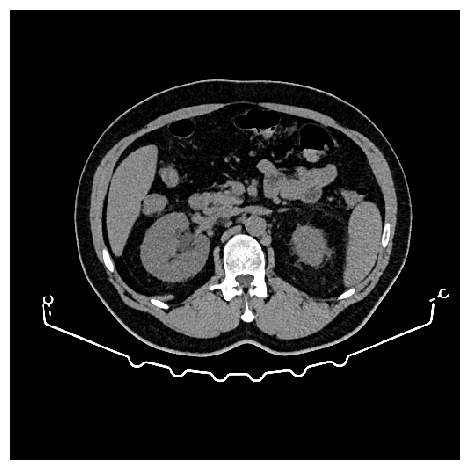

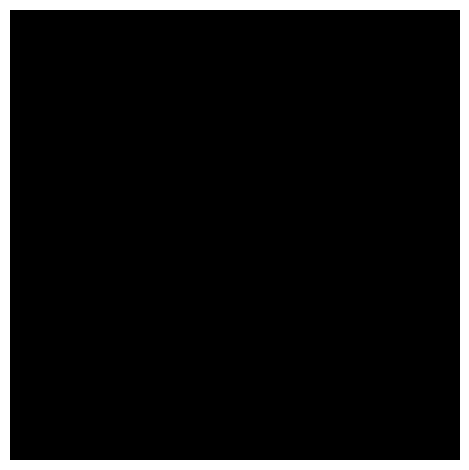

In [4]:
image_x = random.randint(0, len(X))
print(image_x)
plt.axis("off")
imshow(X[image_x])
plt.show()
plt.axis("off")
imshow(np.squeeze(y[image_x]))
plt.show()

In [6]:
best_model = tf.keras.models.load_model('UNET 5x2-fold models/model1_4fold.h5')

2023-09-15 14:25:08.522671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-15 14:25:08.742448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-15 14:25:08.742520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-15 14:25:08.743755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [144]:
acc= []
jacc = []
f1 = []
prec = []
rec = []

for i in range(0, len(X)):
    sample_image = X[i]
    sample_mask = y[i].astype(np.uint8).flatten()
    prediction = best_model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
    predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
        
    acc.append(accuracy_score(sample_mask, predicted_mask))
    if(precision_score(sample_mask, predicted_mask) > 0):
        jacc.append(jaccard_score(sample_mask, predicted_mask))
        f1.append(f1_score(sample_mask, predicted_mask))
        prec.append(precision_score(sample_mask, predicted_mask))
        rec.append(recall_score(sample_mask, predicted_mask))

/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/skl

In [146]:
print("Accuracy: "+ str(np.mean(acc)) + "+- " + str(np.std(acc)))
print("Jaccard: "+ str(np.mean(jacc)) + "+- " + str(np.std(jacc)))
print("Dice: "+ str(np.mean(f1)) + "+- " + str(np.std(f1)))
print("Precision: "+ str(np.mean(prec)) + "+- " + str(np.std(prec)))
print("Recall: "+ str(np.mean(rec)) + "+- " + str(np.std(rec)))

Accuracy: 0.9998842667560188+- 0.00020926138922785906
Jaccard: 0.44196340097256914+- 0.3402768292188966
Dice: 0.5277161800130987+- 0.36473488147008565
Precision: 0.5277458856012102+- 0.3861847681621056
Recall: 0.6503678407899373+- 0.3252257439606428


# CT Stones Segmentation Evaluation

## Right Kidney Stone (47-51)
## Left Kidney Stone (107-109)
## Ureter Stone (126-133)
## Prostate Stone (369-373)

In [1]:
def display(display_list, i):
  plt.figure(figsize=(15, 15))

  title = ['Input image ('+str(i)+')', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()
  
i = random.randint(0, len(X))
i = 370
sample_image = X[i]
sample_mask = y[i]
prediction = best_model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask], i)

sample_mask = y[i].astype(np.uint8).flatten()
predicted_mask = predicted_mask.flatten()


print("Accuracy: "+ str(accuracy_score(sample_mask, predicted_mask)))
print("Jaccard: "+ str(jaccard_score(sample_mask, predicted_mask)))
print("Dice: "+ str((2*jaccard_score(sample_mask, predicted_mask))/(1+jaccard_score(sample_mask, predicted_mask))))
print("Precision: "+ str(precision_score(sample_mask, predicted_mask)))
print("Recall: "+ str(recall_score(sample_mask, predicted_mask)))

NameError: name 'random' is not defined